In [1]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
load_dotenv()
engine = create_engine(os.getenv('MYSQL_URI')).connect()

In [3]:
logs = pd.concat([pd.read_sql_table('logs-dev', engine), pd.read_sql_table('logs', engine)], ignore_index=True)

In [4]:
logs.columns

Index(['id', 'previous_id', 'datetime', 'chat_index', 'wh', 'ml', 'g_co2',
       'usd_in', 'usd_cache', 'usd_out', 'tokens', 'input_tokens',
       'input_tokens_tokenizer', 'output_tokens', 'output_tokens_tokenizer',
       'cached_tokens', 'total_tokens', 'total_wh', 'total_ml', 'total_co2',
       'total_usd', 'total_tokens_session', 'avg_tokens', 'avg_wh', 'avg_ml',
       'avg_co2', 'avg_usd'],
      dtype='object')

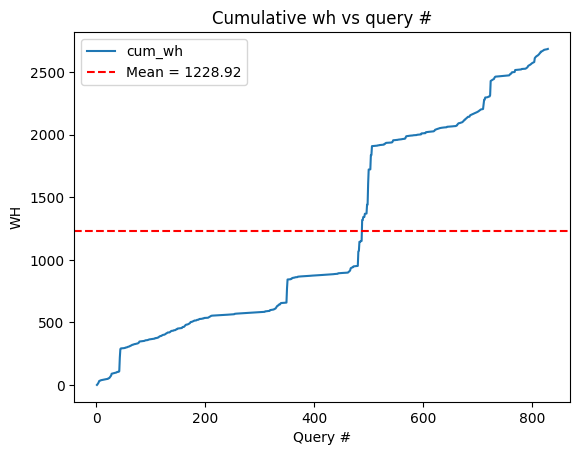

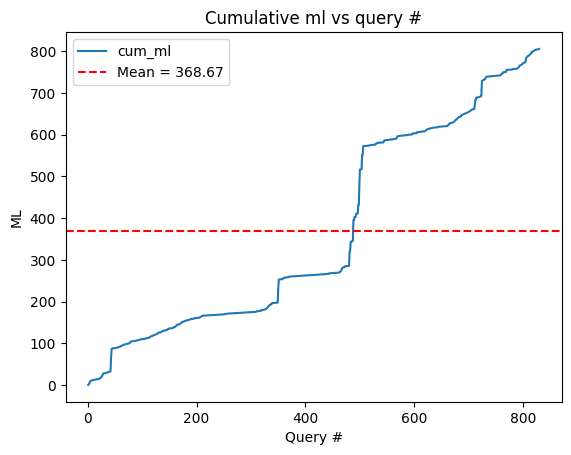

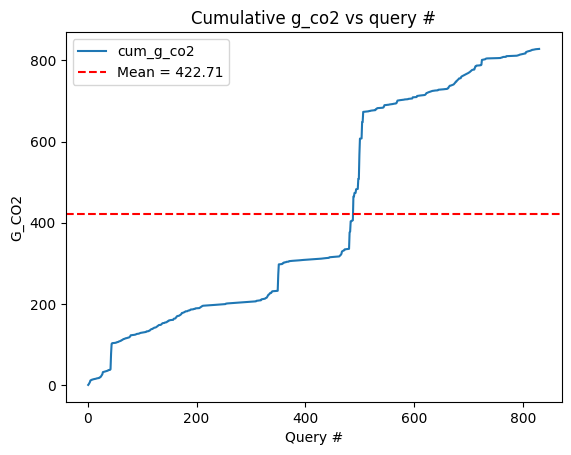

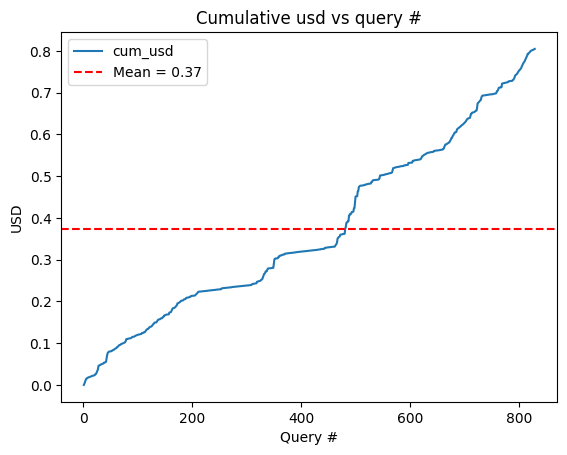

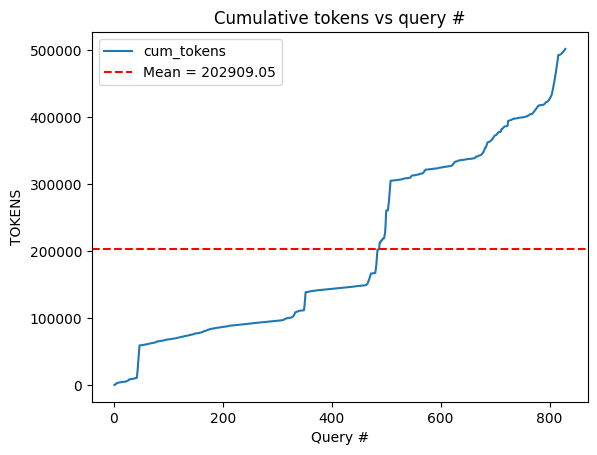

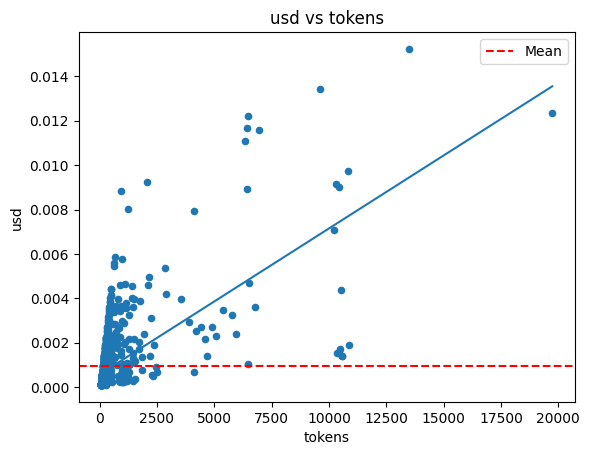

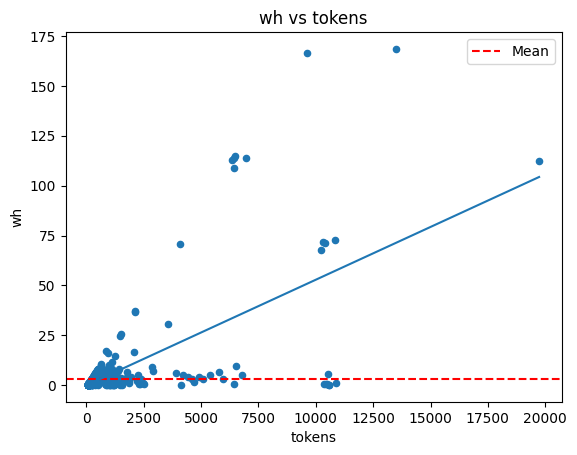

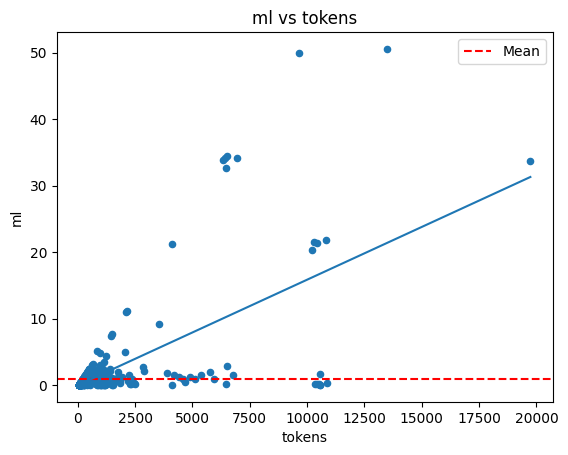

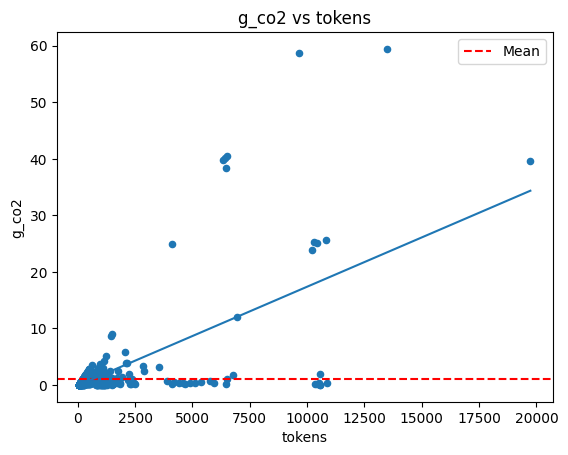

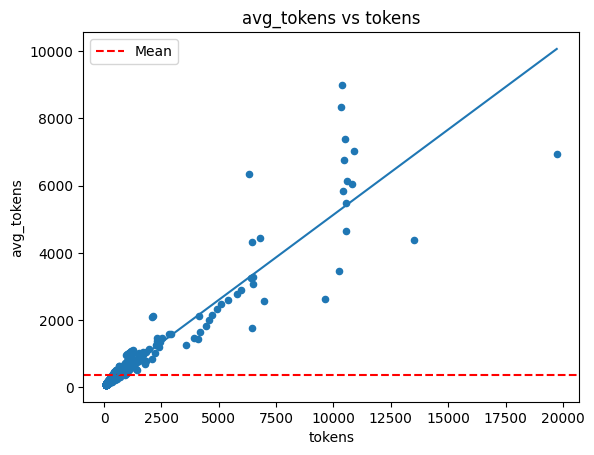

In [5]:
df = logs.copy()
df['usd'] = df['usd_in'] + df['usd_out'] + df['usd_cache']
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['datetime', 'id']).reset_index(drop=True)
df['query_n'] = np.arange(1, len(df)+1)

metrics = ['wh','ml','g_co2','usd','tokens']
for m in metrics:
    df[m] = df[m].fillna(0)
    df[f'cum_{m}'] = df[m].cumsum()

# 1) Cumulative growth
for m in metrics:
    ax = df.plot(x='query_n', y=f'cum_{m}', legend=False,
                 title=f'Cumulative {m} vs query #')
    ax.axhline(df[f'cum_{m}'].mean(), color='r', linestyle='--', label='Mean = {:.2f}'.format(df[f'cum_{m}'].mean()))
    ax.set_xlabel('Query #'); ax.set_ylabel(m.upper())
    ax.legend()
    plt.show()
    ax.set_yscale('log')
    ax.axhline(df[f'cum_{m}'].mean(), color='r', linestyle='--', label='Mean')
    ax.set_xlabel('Query #'); ax.set_ylabel(m.upper())
    ax.legend()
    plt.show()

# ) Tokens → resource scaling
for m in ['usd','wh','ml','g_co2', 'avg_tokens']:
    ax = df.plot.scatter(x='tokens', y=m, title=f'{m} vs tokens')
    ax.axhline(df[m].mean(), color='r', linestyle='--', label='Mean')
    # Simple linear fit
    t = df['tokens'].to_numpy(); y = df[m].to_numpy()
    if np.isfinite(t).all() and np.isfinite(y).all() and t.sum() > 0:
        b1, b0 = np.polyfit(t, y, 1)
        xs = np.linspace(t.min(), t.max(), 100)
        ax.plot(xs, b1*xs + b0)
    ax.legend()
    plt.show()
